In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


# Models/get_models.py

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
    GRU,
    Input,
    GlobalAveragePooling1D,
    MultiHeadAttention,
    LayerNormalization,
    Add,
)


def get_machine_learning_models():
    """
    Returns a dictionary of machine learning models with their names as keys.
    """

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "Naive Bayes": MultinomialNB(),
    }

    return models


def get_deep_learning_models(vocab_size=20000, max_len=500, embed_dim=128, num_heads=4):
    """
    Returns a dictionary of deep learning models with their names as keys.
    """
    models = {}

    # 1. Simple Feedforward
    models["Simple Feedforward"] = Sequential(
        [
            Dense(128, activation="relu", input_shape=(500,)),
            Dropout(0.5),
            Dense(1, activation="sigmoid"),
        ]
    )

    # 2. LSTM Model
    lstm_input = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(lstm_input)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)
    models["LSTM"] = Model(inputs=lstm_input, outputs=output)

    # 3. GRU Model
    gru_input = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(gru_input)
    x = GRU(64)(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)
    models["GRU"] = Model(inputs=gru_input, outputs=output)

    # 4. Transformer-like Model (simple attention block)
    trans_input = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(trans_input)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)
    models["Transformer-Attention"] = Model(inputs=trans_input, outputs=output)

    return models


2025-08-07 19:07:36.075377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754593656.358105      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754593656.431380      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# src/preprocess_data.py

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def preprocess_data(df):
    df = df.dropna().drop_duplicates()
    X = clean_text(df["review"])
    y = df["sentiment"].map({"positive": 1, "negative": 0}).astype("float32")

    # Get both representations
    X_tfidf = get_embeddings(X, method="tfidf")
    X_seq = get_embeddings(X, method="sequence")

    # Split both
    X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=42
    )
    X_seq_train, X_seq_test, _, _ = train_test_split(
        X_seq, y, test_size=0.2, random_state=42
    )

    print("Data split into training and testing sets successfully.")
    return X_tfidf_train, X_tfidf_test, X_seq_train, X_seq_test, y_train, y_test


def clean_text(X):
    # Example cleaning function, modify as needed
    X = X.str.replace(r"[^a-zA-Z\s]", "", regex=True)
    print("Text data cleaned successfully.")
    return X


def get_embeddings(X, method="tfidf", max_features=20000, max_len=500):
    if method == "tfidf":
        vectorizer = TfidfVectorizer(max_features=max_features)
        X_vec = vectorizer.fit_transform(X)
        print("TF-IDF embeddings generated successfully.")
        return X_vec

    elif method == "sequence":
        tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
        tokenizer.fit_on_texts(X)
        sequences = tokenizer.texts_to_sequences(X)
        padded = pad_sequences(
            sequences, maxlen=max_len, padding="post", truncating="post"
        )
        print("Sequence embeddings generated successfully.")
        return padded

# src/train_models.py

In [4]:
def train_models(X_tfidf_train, y_train, X_seq_train):
    """
    Trains and returns a dictionary of machine learning and deep learning models.
    """
    ml_models = get_machine_learning_models()
    dl_models = get_deep_learning_models()

    # Train machine learning models on TF-IDF features
    for name, model in ml_models.items():
        print(f"\nTraining {name} model...")
        model.fit(X_tfidf_train, y_train)
        print(f"{name} model training completed.")

    # Train deep learning models on sequence data
    for name, model in dl_models.items():
        print(f"\nTraining {name} model...")
        model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
        )
        # Add verbose output for deep learning models
        history = model.fit(
            X_seq_train,
            y_train,
            epochs=10,
            batch_size=32,
            verbose=1,  # Set verbose=1 to print progress for each epoch
        )
        print(f"{name} model training completed.")
        # Print training accuracy for each epoch
        for epoch, acc in enumerate(history.history["accuracy"], 1):
            print(f"Epoch {epoch}: Training Accuracy = {acc:.4f}")

    print("\nAll models trained successfully.")
    return {**ml_models, **dl_models}

# test/evaluate.py

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model


def evaluate_model(model, test_data, test_labels):
    """
    Evaluates the given model on the test data and returns the accuracy.
    """
    model_name = model.name if isinstance(model, Model) else model.__class__.__name__
    print(f"\nEvaluating model: {model_name}")

    if hasattr(model, "predict"):
        if isinstance(model, Model):  # Keras model
            print("Predicting on test data...")
            predictions = model.predict(
                test_data, verbose=1
            )  # Set verbose=1 to show progress
            # Convert probabilities to binary class labels (sigmoid output)
            if predictions.shape[-1] == 1:
                predictions = (predictions > 0.5).astype("int32").flatten()
            else:
                predictions = np.argmax(predictions, axis=-1)
        else:  # Scikit-learn model
            print("Predicting on test data...")
            predictions = model.predict(test_data)

        accuracy = accuracy_score(test_labels, predictions)
        print(f"{model_name} Accuracy: {accuracy:.4f}")
        return accuracy
    else:
        raise ValueError(f"Unsupported model type: {type(model)}")

# src/visualize_most_freq_words.py

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def visualize_most_frequent_words(df):
    positive_reviews = df[df["sentiment"] == "positive"]["review"].str.cat(sep=" ")
    negative_reviews = df[df["sentiment"] == "negative"]["review"].str.cat(sep=" ")

    wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(
        positive_reviews
    )
    wordcloud_neg = WordCloud(
        width=800, height=400, background_color="black", colormap="Reds"
    ).generate(negative_reviews)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_pos, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Frequent Positive Words")

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_neg, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Frequent Negative Words")

    plt.tight_layout()
    plt.show()

# src/main.py

******************** Main ********************

Step 1: Loading dataset...
Data loaded successfully.

Step 2: Preprocessing data...
Text data cleaned successfully.
TF-IDF embeddings generated successfully.
Sequence embeddings generated successfully.
Data split into training and testing sets successfully.
Data preprocessed successfully.

Step 3: Training models...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754593689.538414      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training Logistic Regression model...
Logistic Regression model training completed.

Training Random Forest model...
Random Forest model training completed.

Training Naive Bayes model...
Naive Bayes model training completed.

Training Simple Feedforward model...
Epoch 1/10


I0000 00:00:1754593802.545869      98 service.cc:148] XLA service 0x7f813c0532d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754593802.546350      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754593802.760485      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  74/1240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4881 - loss: 1046.7637

I0000 00:00:1754593803.618107      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5008 - loss: 363.4075
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5084 - loss: 3.2060
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5131 - loss: 1.1874
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5116 - loss: 0.8959
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5041 - loss: 0.7966
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5019 - loss: 0.7399
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5053 - loss: 0.7192
Epoch 8/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5023 - loss: 0.7154
Epoch 9/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5045 - loss: 0.7028
Epoch 10/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5025 - loss: 0.7038
Simple Feedforward model training completed.
Epoch 1: Training Accuracy = 0.5003
Epoch 2: Training Accuracy = 0.5043
Epoch 3: Tr

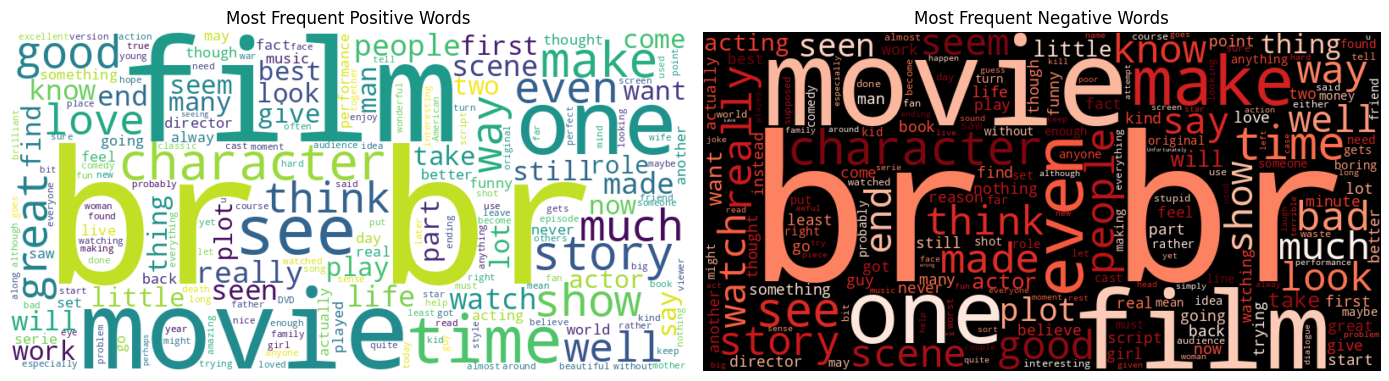

Visualization completed.
******************** Return ********************


In [7]:
import pandas as pd
import warnings

# Suppress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def main():
    print("*" * 20, "Main", "*" * 20)

    # Step 1: Download data
    print("\nStep 1: Loading dataset...")
    df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
    print("Data loaded successfully.")

    # Step 2: Preprocess text
    print("\nStep 2: Preprocessing data...")
    X_tfidf_train, X_tfidf_test, X_seq_train, X_seq_test, y_train, y_test = (
        preprocess_data(df)
    )
    print("Data preprocessed successfully.")

    # Step 3: Train models
    print("\nStep 3: Training models...")
    models = train_models(X_tfidf_train, y_train, X_seq_train)
    print("Models trained successfully.")

    # Step 4: Evaluate models
    print("\nStep 4: Evaluating models...")
    accuracy_results = {}
    for name, model in models.items():
        if name in ["Logistic Regression", "Random Forest", "Naive Bayes"]:
            X_test = X_tfidf_test
        else:
            X_test = X_seq_test

        accuracy = evaluate_model(model, X_test, y_test)
        accuracy_results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")

    print("\nModel evaluation completed.")
    print("Accuracy Results:", accuracy_results)

    # Step 5: Visualize most frequent words
    print("\nStep 5: Visualizing most frequent words...")
    visualize_most_frequent_words(df)
    print("Visualization completed.")

    print("*" * 20, "Return", "*" * 20)
    

if __name__ == "__main__":
    main()